**STEP 1) CONNECTING GOOGLE COLAB TO GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

# Change working directory to your Google Drive
os.chdir('/content/drive/MyDrive/')

# Cloning the repository in your Google Drive.
# If you are doing inference right after doing training then no need to clone as during training process, this GitHub repo is cloned.
!git clone https://github.com/malayjoshi13/Describer.git

# Change working directory to your cloned repository
os.chdir('/content/drive/MyDrive/Describer/')

In [ ]:
# Enter location of folder inside directory named "Describer" in your Google Drive, from where you will fetch trained model and needed files.
# Two options:
#     "temporary" (if evaluating on your own trained model) or
#     "default_model_checkpoint" (if evaluating on default pre-trained model)
chkp_location = "./default_model_checkpoint/"

<BR><BR><BR>

**STEP 2) UPLOAD A TEST IMAGE FROM LEFT PANEL AND PUT PATH OF IMAGE HERE TO GENERATE CAPTION FOR IT!**

In [8]:
image_path =  '/content/test.png'

<BR><BR><BR>

**STEP 3) IMPORTING LIBRARIES**

In [4]:
import numpy as np
from pickle import load
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import string
import glob
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from nltk.translate.bleu_score import corpus_bleu
from time import time

**STEP 4) SOME PARAMETERS TO BE USED HERE**

In [5]:
max_length=34
vocab_size=1652
embedding_dim=200
image_feature_shape=(2048,)

**STEP 5) LOADING PICKELED FILES OF "word_to_index", "index_to_word" and "embedding_matrix" WHICH WE HAVE SAVED DURING TRAINING PERIOD**

In [6]:
filename = chkp_location+'word_to_index.pkl'
word_to_index = load(open(filename, 'rb'))

filename1 = chkp_location+'index_to_word.pkl'
index_to_word = load(open(filename1, 'rb'))

filename2 = chkp_location+'all_captions_GLOVE_embedding.pkl'
embedding_matrix = load(open(filename2, 'rb'))

**STEP 6) ENCODING YOUR IMAGE USING InceptionV3**

In [9]:
pre_trained_model = InceptionV3(weights='imagenet')
input_img_size = pre_trained_model.input_shape[1:3]

encoder = Model(pre_trained_model.input, pre_trained_model.layers[-2].output)

img = load_img(image_path, target_size=input_img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
test_img_encoding = encoder.predict(img)

1/1 [==============================] - 2s 2s/step


**STEP 7) Re-initializing the model and loading saved weights to the model**

In [10]:
# image-encoding pipeline
inputs1 = Input(shape=image_feature_shape)
layer1 = Dropout(0.5)(inputs1)
layer2 = Dense(256, activation='relu')(layer1)

# caption-pipeline
inputs2 = Input(shape=(max_length,))
layerA = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False, mask_zero=True)(inputs2)
layerB = Dropout(0.5)(layerA)
layerC = LSTM(256)(layerB)

# decoder (feed forward) model
merging_point = add([layer2, layerC])
activator = Dense(256, activation='relu')(merging_point)
outputs = Dense(vocab_size, activation='softmax')(activator)

trained_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

trained_model.load_weights(chkp_location+'weights/best.h5')

**STEP 8) WILL KICK-START CAPTION GENERATION PROCESS**

**STEP 8.1) GREEDY SEARCH**

As the model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.



In [19]:
def greedy_search():
  caption = 'startseq'

  for i in range(max_length):
    hints_of_caption = [word_to_index[word] for word in caption.split() if word in word_to_index]
    # becaue of "pad_sequences", "hints_of_caption" for first iteration becomes [1, 0, 0,....31 more zeroes], so that "hints_of_caption" of every
    # iteration becomes of same length equal to "max_length", i.e. 34
    padded_hints_of_caption = pad_sequences([hints_of_caption], maxlen=max_length)
    yhat = trained_model.predict([test_img_encoding, padded_hints_of_caption])
    # then out of all 1798 (=most_occuring_words in the vocabulary) possible outputs for next word, we choose ouput having highest probability
    yhat = np.argmax(yhat)
    # then we convert this label encoded output, into label decoded output, in simple terms if yhat=[6] then "index_to_word" will convert it to yhat=['stairs']
    word = index_to_word[yhat]
    # then "caption" = "startseq"+"stairs" = "startseq stairs"
    caption += ' ' + word
    if word == 'endseq':
        break

  finalz = caption.split()
  finalz = finalz[1:-1]
  final_captionz = ' '.join(finalz)

  return final_captionz

**STEP 8.2) BEAM SEARCH**

Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions. In the end, we take the one with the highest probability and go through it till we encounter 'endseq' or reach the maximum caption length.





In [21]:
def beam_search(beam_index):
    start = [word_to_index["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = trained_model.predict([test_img_encoding,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [index_to_word[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

<BR><BR><BR>

**STEP 8) HERE IS YOUR IMAGE AND THE CAPTION BEST DESCRIBING IT!**

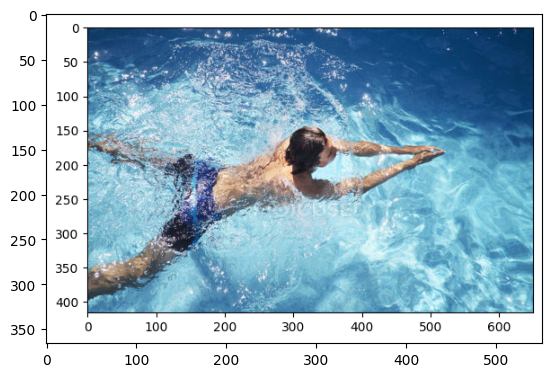

1/1 [==============================] - 0s 50ms/step
Greedy: young girl in swimming trunks trunks in pool
Beam Search, K = 3: young girl in swimming swimming trunks in pool


In [22]:
x=plt.imread(image_path)
plt.imshow(x)
plt.show()

print("Greedy:",greedy_search())
print("Beam Search, K = 3:",beam_search(beam_index = 3))
# print("Beam Search, K = 5:",beam_search(beam_index = 5))
# print("Beam Search, K = 7:",beam_search(beam_index = 7))
# print("Beam Search, K = 10:",beam_search(beam_index = 10))